In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

In [3]:
import keras
import keras.backend as K
import keras.layers as layers
from keras.models import Model
from keras.utils import to_categorical
from keras import callbacks

Using TensorFlow backend.


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [5]:
import util, defs, models

In [6]:
bg_consts, sig_consts, bg_jets, sig_jets = util.load_data()
    
print(bg_consts.shape)
print(sig_consts.shape)

(297233, 96, 3)
(392759, 96, 3)


In [7]:
(X_train, y_train), (X_val, y_val) = util.format_dataset(bg_consts, sig_consts,
                                                         validation_fraction=defs.VALIDATION_FRACTION)

print("Training set:  ", X_train.shape)
print("Validation set:", X_val.shape)

Training set:   (505298, 96, 3)
Validation set: (89168, 96, 3)


In [131]:
calc = models.mk_HL_calc(features=defs.BENCHMARK_HL_ARGS['features'])

HL_train = calc.predict(X_train, batch_size=1024)
HL_val = calc.predict(X_val, batch_size=1024)

print("HL training set:  ", HL_train.shape)
print("HL validation set:", HL_val.shape)

W0918 19:20:54.201882 140094278563648 special_math_ops.py:275] Falling back to exponential-space implementation of einsum() because index "j" is summed over more than two inputs.
W0918 19:20:55.160019 140094278563648 special_math_ops.py:275] Falling back to exponential-space implementation of einsum() because index "j" is summed over more than two inputs.


HL training set:   (505298, 4)
HL validation set: (89168, 4)


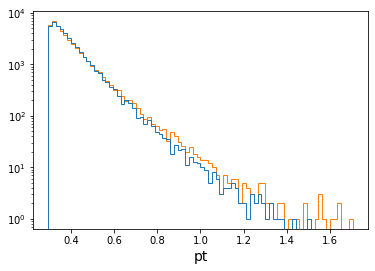

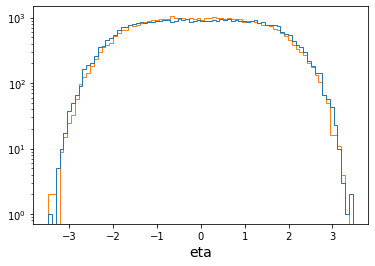

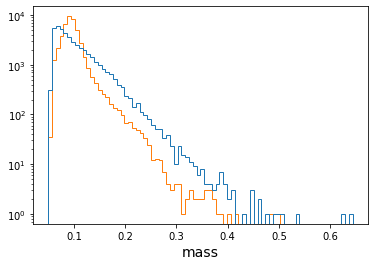

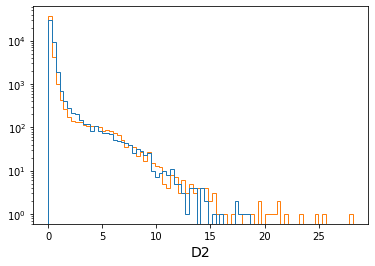

In [132]:
for i,f in enumerate(defs.BENCHMARK_HL_ARGS['features']):
    plt.figure()
    plt.hist([HL_val[y_val==0,i], HL_val[y_val==1,i]], histtype='step', bins=80);
    plt.yscale('log')
    plt.xlabel(f)

In [239]:
K.clear_session()
benchmark_HL_nonaug, benchmark_HL_aug, benchmark_HL_calc = models.mk_benchmark_HL(**defs.BENCHMARK_HL_ARGS)

benchmark_HL = benchmark_HL_nonaug

benchmark_HL.h = util.HistoryCB(val_data=(HL_val, y_val))

benchmark_HL_nonaug.summary()

W0919 14:08:40.282180 140094278563648 special_math_ops.py:275] Falling back to exponential-space implementation of einsum() because index "j" is summed over more than two inputs.
W0919 14:08:41.017888 140094278563648 special_math_ops.py:275] Falling back to exponential-space implementation of einsum() because index "j" is summed over more than two inputs.
W0919 14:08:42.017130 140094278563648 special_math_ops.py:275] Falling back to exponential-space implementation of einsum() because index "j" is summed over more than two inputs.
W0919 14:08:42.748240 140094278563648 special_math_ops.py:275] Falling back to exponential-space implementation of einsum() because index "j" is summed over more than two inputs.


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 4)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 384)               1920      
_________________________________________________________________
dropout_1 (Dropout)          (None, 384)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 384)               147840    
_________________________________________________________________
dropout_2 (Dropout)          (None, 384)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 384)               147840    
_________________________________________________________________
dropout_3 (Dropout)          (None, 384)               0   

In [248]:
epochs = 2

batch_size = 256

learning_rate = 3e-4

K.set_value(benchmark_HL.optimizer.lr, learning_rate)

stopping = callbacks.EarlyStopping(monitor='val_loss', patience=32, verbose=1,
                                   mode='min', restore_best_weights=True)

try:
    benchmark_HL.fit(HL_train, y_train,
                     validation_data=(HL_val, y_val),
                     callbacks=[benchmark_HL.h],
                     batch_size=batch_size,
                     epochs=epochs
                    )
except KeyboardInterrupt:
    pass

Train on 505298 samples, validate on 89168 samples
Epoch 1/2
505298/505298 [==============================] - 10s 19us/step - loss: 0.5547 - val_loss: 0.5502
Epoch 2/2
505298/505298 [==============================] - 10s 20us/step - loss: 0.5541 - val_loss: 0.5500


Validation AUC: 0.7952664414511805
          best: 0.7952664414511805
         ibest: 8/8


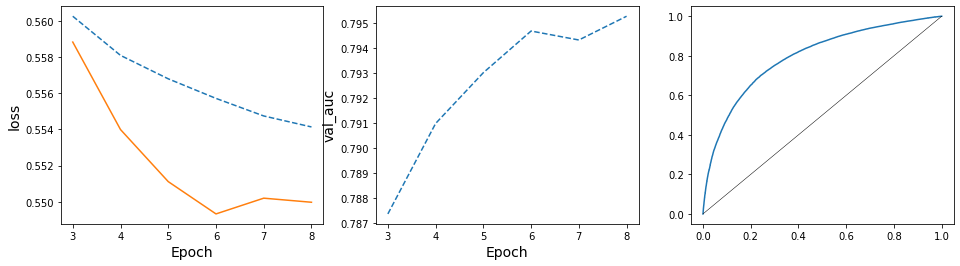

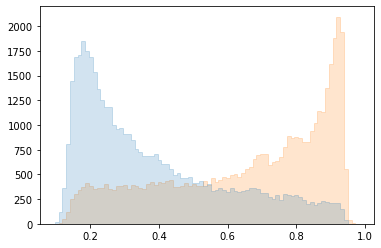

In [249]:
benchmark_HL.h.plot(['loss', 'val_auc', 'roc'], nskip=2,
                    figsize=plt.figaspect(0.25))
print("Validation AUC:", benchmark_HL.h.history['val_auc'][-1])
print("          best:", np.max(benchmark_HL.h.history['val_auc']))
print("         ibest: %d/%d"%(np.argmax(benchmark_HL.h.history['val_auc'])+1, benchmark_HL.h.epoch_total))

plt.figure()
preds_val = benchmark_HL.predict(HL_val, batch_size=512).squeeze()
plt.hist([preds_val[y_val==0], preds_val[y_val==1]], histtype='step', bins=80, fill=True, alpha=0.2);

In [253]:
benchmark_HL_nonaug.evaluate(HL_train, y_train, batch_size=1024)

505298/505298 [==============================] - 1s 2us/step


0.5492838294631468

In [254]:
benchmark_HL_calc.evaluate(X_train, y_train, batch_size=1024)

505298/505298 [==============================] - 79s 156us/step


0.5492838294631468

In [252]:
do_save = False
if do_save:
    benchmark_HL.save("model_benchmark_HL.h5")
    benchmark_HL_calc.save("model_benchmark_HL_calc.h5")

In [ ]:
# best: approx 0.805

In [74]:
plt.hist([HL_val[:,3][y_val==0], HL_val[:,3][y_val==1]], histtype='step', bins=80, fill=True, alpha=0.2, density=True);
plt.figure()
plt.hist([HL_val[:,3][(y_val==0)*(preds_val<0.2)], HL_val[:,3][(y_val==1)*(preds_val<0.2)]], histtype='step', bins=80, density=True);
plt.figure()
plt.hist([HL_val[:,3][(y_val==0)*(preds_val>0.8)], HL_val[:,3][(y_val==1)*(preds_val>0.8)]], histtype='step', bins=80, density=True);

IndexError: index 3 is out of bounds for axis 1 with size 1

In [ ]:
for q in np.quantile(preds_val[y_val==0], (0,0.5,0.7,0.9,0.95,0.99)):
    print(q)
    plt.hist(HL_val[:,3][(y_val==0)*(preds_val>q)], histtype='step', bins=25, range=(0,0.5), color='C0', alpha=0.1, fill=True)
plt.yscale('log');

In [ ]:
for q in np.quantile(preds_val[y_val==1], (1-0.0,1-0.5,1-0.7,1-0.9,1-0.95,1-0.99)):
    print(q)
    plt.hist(HL_val[:,3][(y_val==1)*(preds_val<q)], histtype='step', bins=25, range=(0,0.5), color='C4', alpha=0.1, fill=True)
plt.yscale('log');

In [44]:
save_model = False

if save_model:
    if shuffle_particles:
        file_name = 'model_benchmark_LL_shuff.h5'
    else:
        file_name = 'model_benchmark_LL.h5'
    
    benchmark_LL_nonaug.save(file_name)
    print("Saved to", file_name)